## Line histogram test

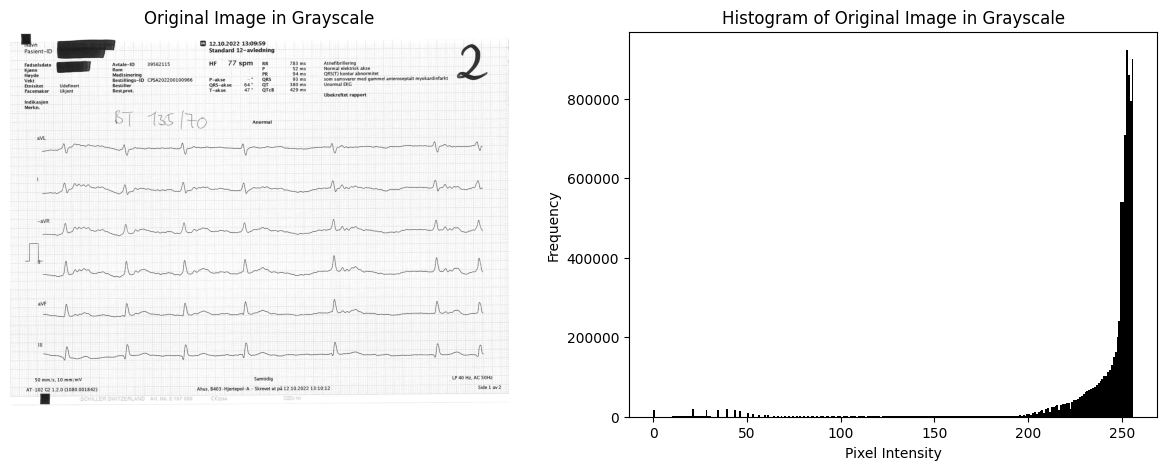

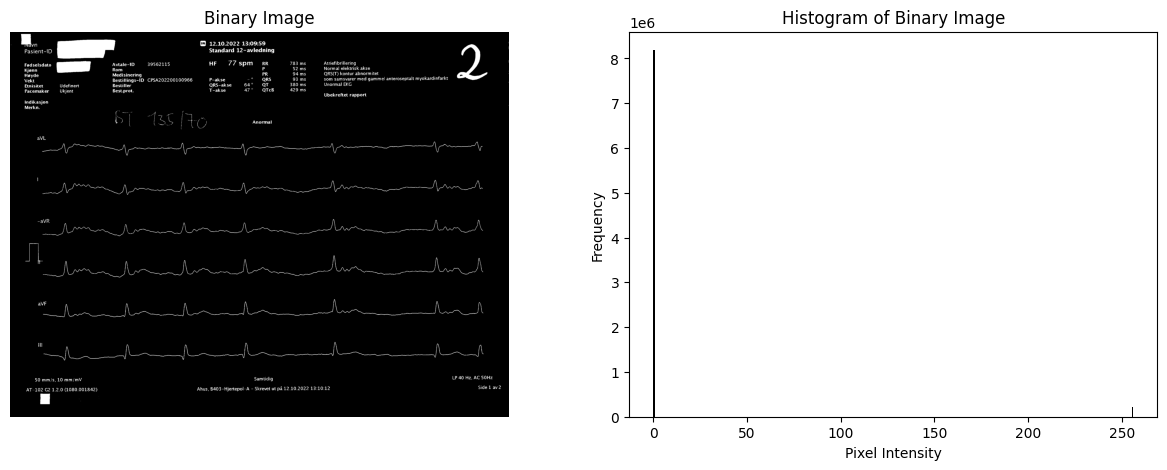

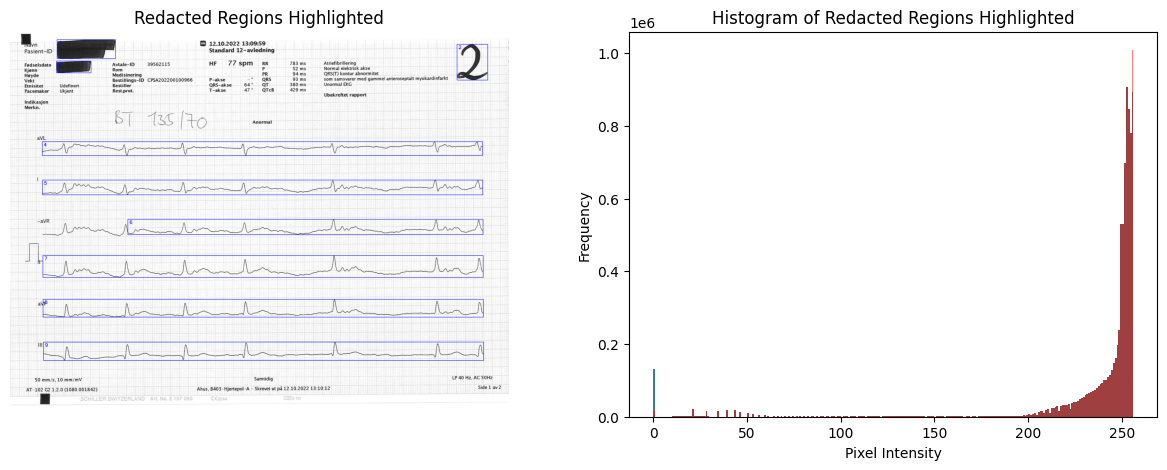

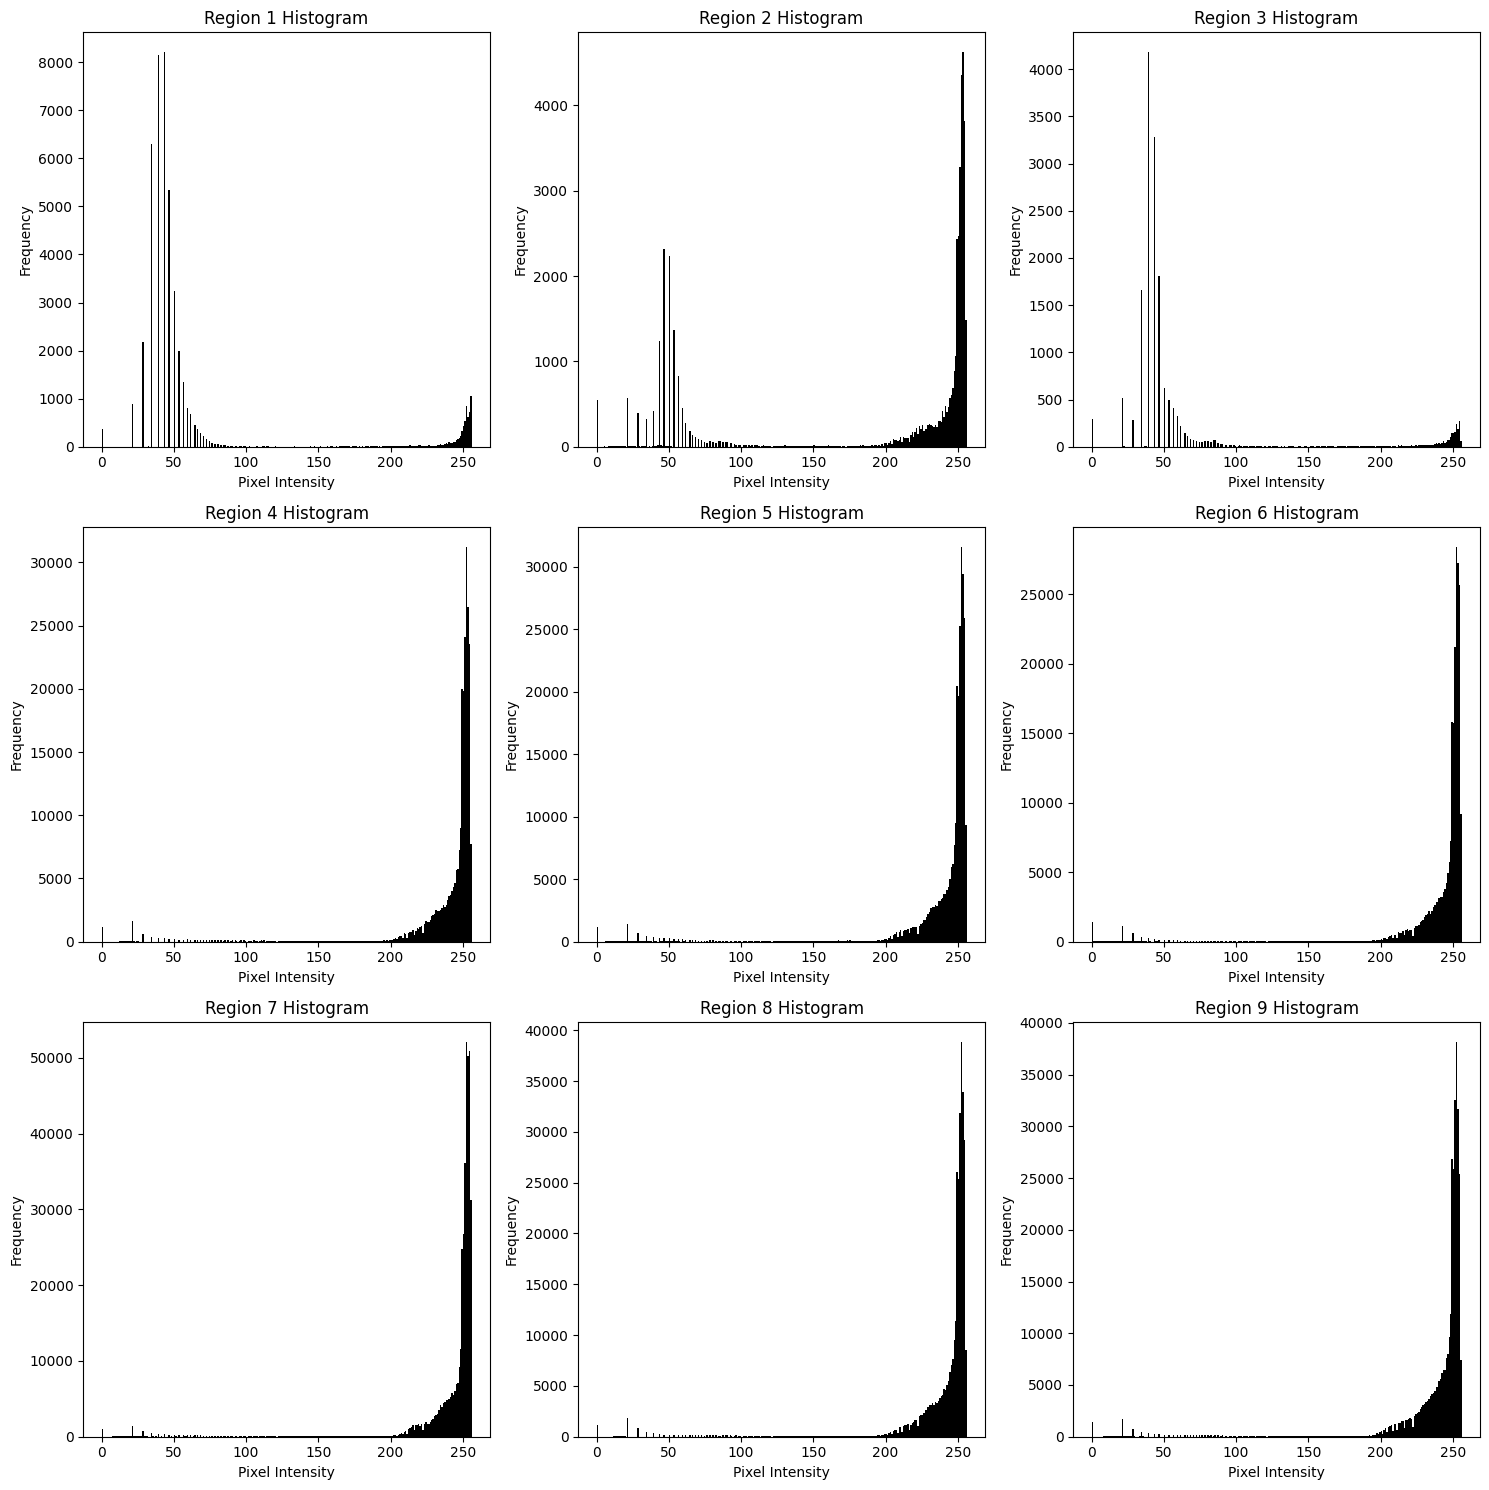

In [15]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import sys
from scipy import ndimage  # Make sure to import ndimage for `find_objects`

# Helper function to plot images
def plot_image(image, title, cmap='gray'):
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()



def align_leads(contour_coords, num_points=5000):
    aligned_coords = []
    for coords in contour_coords:
        x = coords[:, 0]
        y = coords[:, 1]
        f_interp = interp1d(x, y, kind='linear', fill_value="extrapolate")
        x_new = np.linspace(x.min(), x.max(), num_points)
        y_new = f_interp(x_new)
        aligned_coords.append(np.column_stack((x_new, y_new)))
    return aligned_coords





def plot_aligned_coordinates(aligned_coords):
    plt.figure(figsize=(10, 8))
    
    # Reverse the order of aligned leads to match top-to-bottom ordering
    for i, coords in enumerate(reversed(aligned_coords)):
        plt.plot(coords[:, 0], coords[:, 1], label=f'Lead {i+1}')
    
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.title('Aligned ECG Signal Leads')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()


def apply_kmeans(image, n_clusters=6):
    Z = image.reshape((-1, 1))  # Flatten the image
    Z = np.float32(Z)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv.kmeans(Z, n_clusters, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
    segmented_image = labels.reshape((image.shape))
    return segmented_image, centers

def apply_kmeans_dynamic(image):
    Z = image.reshape((-1, 1))
    Z = np.float32(Z)
    n_clusters = min(6, len(np.unique(image)))  # Example logic to determine clusters
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv.kmeans(Z, n_clusters, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
    segmented_image = labels.reshape((image.shape))
    return segmented_image, centers

from sklearn.mixture import GaussianMixture

def apply_gmm(image, n_components=6):
    Z = image.reshape((-1, 1))
    Z = np.float32(Z)

    gmm = GaussianMixture(n_components=n_components, covariance_type='tied')
    gmm.fit(Z)
    labels = gmm.predict(Z)
    
    segmented_image = labels.reshape(image.shape)
    return segmented_image, gmm.means_




def create_binary_masks(segmented_image, n_clusters):
    binary_masks = [(segmented_image == i).astype(np.uint8) * 255 for i in range(n_clusters)]
    return binary_masks

def extract_contour_coordinates(binary_masks):
    contour_coordinates = []
    for mask in binary_masks:
        contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            coords = contour[:, 0, :]  # Extract x and y coordinates
            contour_coordinates.append(coords)
    return contour_coordinates

def resample_contour(contour, num_points=100):
    x = contour[:, 0]
    y = contour[:, 1]
    f_interp = interp1d(np.arange(len(x)), x, kind='linear', fill_value="extrapolate")
    x_new = np.linspace(0, len(x) - 1, num_points)
    x_resampled = f_interp(x_new)
    f_interp = interp1d(np.arange(len(y)), y, kind='linear', fill_value="extrapolate")
    y_resampled = f_interp(x_new)
    return np.column_stack((x_resampled, y_resampled))

def compare_gradients(contour1, contour2, threshold=0.5, num_points=100):
    # Resample contours
    contour1_resampled = resample_contour(contour1, num_points)
    contour2_resampled = resample_contour(contour2, num_points)
    
    # Calculate gradients for each contour
    gradient1 = np.diff(contour1_resampled, axis=0)
    gradient2 = np.diff(contour2_resampled, axis=0)

    # Calculate mean squared difference between gradients
    mse = np.mean((gradient1 - gradient2) ** 2, axis=0)

    # Return True if all MSE values are below the threshold
    return np.all(mse < threshold)

# def filter_and_merge_leads(contour_coords, min_size=500, y_threshold=10, gradient_threshold=0.5):
#     large_contours = [coords for coords in contour_coords if len(coords) > min_size]

#     merged_leads = []
#     current_lead = []
#     for i, coords in enumerate(large_contours):
#         if not current_lead:
#             current_lead.append(coords)
#             continue

#         if np.abs(coords[:, 1].mean() - current_lead[0][:, 1].mean()) < y_threshold and compare_gradients(coords, current_lead[0], gradient_threshold):
#             current_lead.append(coords)
#         else:
#             merged_leads.append(np.vstack(current_lead))
#             current_lead = [coords]
#     if current_lead:
#         merged_leads.append(np.vstack(current_lead))

#     return merged_leads

def filter_and_merge_leads(contour_coords, min_size=500, y_threshold=10, gradient_threshold=0.5, proximity_threshold=20):
    large_contours = [coords for coords in contour_coords if len(coords) > min_size]

    merged_leads = []
    current_lead = []
    
    def is_similar_lead(coords1, coords2, y_threshold, proximity_threshold):
        # Check if the average y-coordinate is close
        avg_y1 = coords1[:, 1].mean()
        avg_y2 = coords2[:, 1].mean()
        
        # Check if the contours are close in y and x direction
        y_similar = np.abs(avg_y1 - avg_y2) < y_threshold
        
        # Check proximity based on the end of one contour and the start of the other
        x_end1 = coords1[:, 0].max()
        x_start2 = coords2[:, 0].min()
        x_proximity = np.abs(x_end1 - x_start2) < proximity_threshold
        
        return y_similar and x_proximity
    
    for i, coords in enumerate(large_contours):
        if not current_lead:
            current_lead.append(coords)
            continue
        
        # Compare current contour with the first contour in current_lead
        if is_similar_lead(coords, current_lead[0], y_threshold, proximity_threshold):
            current_lead.append(coords)
        else:
            merged_leads.append(np.vstack(current_lead))
            current_lead = [coords]
    
    if current_lead:
        merged_leads.append(np.vstack(current_lead))

    return merged_leads


def calculate_vertical_spans_for_leads(merged_leads):
    return [coords[:, 1].max() - coords[:, 1].min() for coords in merged_leads]

def plot_histograms_for_leads(merged_leads):
    # Create a figure with subplots arranged in a single row
    plt.figure(figsize=(18, 6))
    
    for i, coords in enumerate(merged_leads):
        plt.subplot(2, 6, i+1)  # Change the arrangement to accommodate more histograms
        if coords.size > 0:  # Check if there are contours
            plt.hist(coords[:, 1], bins=20, edgecolor='black')
            plt.title(f'Lead {i+1}')
            plt.xlabel('Vertical Span (pixels)')
            plt.ylabel('Frequency')
        else:
            plt.title(f'Lead {i+1} - No Data')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()





def enforce_six_leads_by_start_points(merged_coords):
    # If there are six or fewer leads, return them as is
    if len(merged_coords) <= 6:
        return merged_coords
    
    # Calculate the ranges for each lead
    lead_ranges = [(i, coords[:, 0].max() - coords[:, 0].min()) for i, coords in enumerate(merged_coords)]
    lead_ranges.sort(key=lambda x: x[1], reverse=True)  # Sort by range in descending order
    
    # Select the top 6 leads based on the range
    selected_indices = [i for i, _ in lead_ranges[:6]]
    
    # Return the selected leads while preserving the original order
    selected_coords = [merged_coords[i] for i in sorted(selected_indices)]
    
    return selected_coords



def filter_small_contours(contours, min_area=1000):
    filtered_contours = [c for c in contours if cv.contourArea(c) > min_area]
    return filtered_contours

def merge_contours(contours, proximity_threshold=20):
    merged_contours = []
    for i, contour in enumerate(contours):
        merged = False
        for j, merged_contour in enumerate(merged_contours):
            if np.linalg.norm(contour.mean(axis=0) - merged_contour.mean(axis=0)) < proximity_threshold:
                merged_contours[j] = np.vstack([merged_contour, contour])
                merged = True
                break
        if not merged:
            merged_contours.append(contour)
    return merged_contours

def plot_time_amplitude_single_column(time_amplitude_df):
    """
    Plots each lead's time-amplitude in a single column layout.
    
    :param time_amplitude_df: DataFrame containing time and amplitude columns for the leads.
    """
    # Dynamically determine the number of leads from the DataFrame columns
    lead_columns = [col for col in time_amplitude_df.columns if '_time' in col]
    num_leads = len(lead_columns)

    plt.figure(figsize=(10, num_leads * 2))

    # Iterate over the leads and plot only the ones that are present in time_amplitude_df
    for i in range(1, num_leads + 1):
        time_col = f'Lead_{i}_time'
        amp_col = f'Lead_{i}_amplitude'

        # Only plot if both time and amplitude columns exist in the DataFrame
        if time_col in time_amplitude_df.columns and amp_col in time_amplitude_df.columns:
            plt.subplot(num_leads, 1, i)
            plt.plot(time_amplitude_df[time_col], time_amplitude_df[amp_col])
            plt.title(f'Lead {i}')
            plt.xlabel('Time')
            plt.ylabel('Amplitude')
        else:
            print(f"Skipping Lead {i} as it's missing in the DataFrame")

    plt.tight_layout()
    plt.show()


def plot_time_amplitude_overlay(image_path, time_amplitude_df, pixels_per_mm_x, pixels_per_mm_y):
    """
    Plots the ECG leads overlaying on the original ECG image.

    :param image_path: The path to the original ECG image or the image matrix.
    :param time_amplitude_df: DataFrame containing the time and amplitude for each lead.
    :param pixels_per_mm_x: The pixel-to-mm conversion factor for the x-axis (time).
    :param pixels_per_mm_y: The pixel-to-mm conversion factor for the y-axis (amplitude).
    """

    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed

    # Plot the original ECG image
    plt.imshow(image_path, cmap='gray')

    # Conversion factors (inverse of what was used to convert from pixels to time/amplitude)
    pixel_per_time = pixels_per_mm_x * 50  # 50 mm = 1 second
    pixel_per_amplitude = pixels_per_mm_y * 10  # 10 mm = 1 mV

    # Dynamically determine the number of leads from the DataFrame columns
    lead_columns = [col for col in time_amplitude_df.columns if '_time' in col]
    num_leads = len(lead_columns)

    # Overlay each lead present in time_amplitude_df
    for i in range(1, num_leads + 1):
        time_col = f'Lead_{i}_time'
        amp_col = f'Lead_{i}_amplitude'
        
        if time_col in time_amplitude_df.columns and amp_col in time_amplitude_df.columns:
            # Convert time and amplitude back to pixel coordinates
            x_pixels = time_amplitude_df[time_col] * pixel_per_time
            y_pixels = time_amplitude_df[amp_col] * pixel_per_amplitude

            plt.plot(x_pixels, y_pixels, label=f'Lead {i}', linewidth=2)  # Plot each lead
        else:
            print(f"Skipping Lead {i} as it's missing in the DataFrame")

    plt.title('Overlay of Extracted ECG Leads on Original Image')
    plt.xlabel('Time (pixels)')
    plt.ylabel('Amplitude (pixels)')
    plt.legend()
    plt.axis('off')  # Hide axis since we're overlaying on an image
    plt.show()



# Function to extract time and amplitude from aligned leads
def extract_time_amplitude(aligned_leads, pixels_per_mm_x, pixels_per_mm_y):
    lead_data = {}

    # Conversion factors
    time_per_pixel = 1 / (pixels_per_mm_x * 50)  # 50 mm = 1 second
    amplitude_per_pixel = 1 / (pixels_per_mm_y * 10)  # 10 mm = 1 mV

    # Reverse the order of aligned leads to match top-to-bottom ordering
    aligned_leads = list(reversed(aligned_leads))

    for i, lead in enumerate(aligned_leads):
        time_values = lead[:, 0] * time_per_pixel  # Convert x-coordinates to time
        amplitude_values = lead[:, 1] * amplitude_per_pixel  # Convert y-coordinates to amplitude
        lead_data[f'Lead_{i+1}_time'] = time_values
        lead_data[f'Lead_{i+1}_amplitude'] = amplitude_values
    
    return pd.DataFrame(lead_data)



def plot_binary_masks(binary_masks):
    num_masks = len(binary_masks)
    cols = 3
    rows = (num_masks + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    axes = axes.flatten()

    plt.suptitle('Binary Masks')
    
    for i, mask in enumerate(binary_masks):
        axes[i].imshow(mask, cmap='gray')
        axes[i].set_title(f'Mask {i+1}')
        axes[i].axis('off')

    for j in range(num_masks, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def plot_contour_coordinates(contour_coords):
    plt.figure(figsize=(10, 8))
    plt.title('Contour Coordinates')

    for i, coords in enumerate(contour_coords):
        plt.plot(coords[:, 0], coords[:, 1], label=f'Contour {i+1}')
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.legend()
    plt.show()

def plot_merged_leads(merged_leads):
    plt.figure(figsize=(10, 8))
    plt.title('Merged Leads')

    for i, coords in enumerate(merged_leads):
        plt.plot(coords[:, 0], coords[:, 1], label=f'Merged Lead {i+1}')
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

def plot_final_leads(final_leads):
    plt.figure(figsize=(10, 8))
    plt.title('Final Leads')

    for i, coords in enumerate(final_leads):
        plt.plot(coords[:, 0], coords[:, 1], label=f'Final Lead {i+1}')
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.legend()
    plt.show()
    
# Main processing function
def process_ecg_image(image_path, padding_size=50):
    # Step 1: Load the image
    image = cv.imread(image_path)
    if image is None:
        print('Cannot open image: ' + image_path)
        sys.exit(0)

    plot_image(image, 'Original Image')

    # Convert the image to a custom Image class
    img_obj = CustomImage(image)

    # Initialize Preprocessor
    preprocessor = Preprocessor()

    # Apply preprocessing
    preprocessed_img_obj, rect = preprocessor.preprocess(img_obj)
    
    # Convert the preprocessed image back to numpy array
    preprocessed_image = preprocessed_img_obj.array

    # Plot the preprocessed image
    plot_image(preprocessed_image, 'Preprocessed Image')

    # Add padding to the left and right of the preprocessed image
    padded_image = cv.copyMakeBorder(
        preprocessed_image, 
        top=0, bottom=0, left=padding_size, right=padding_size, 
        borderType=cv.BORDER_CONSTANT, value=255  # Assuming the background is white (255)
    )
    
    # Plot the padded image
    plot_image(padded_image, 'Padded Image')

    # Apply GMM segmentation on the padded image
    segmented_image, centers = apply_gmm(padded_image, n_components=6)
    plot_image(segmented_image, "Segmented Image (GMM)", cmap='jet')

    # The rest of the code remains unchanged...
    # Create binary masks and extract contours
    binary_masks = create_binary_masks(segmented_image, n_clusters=6)
    plot_binary_masks(binary_masks)  # Plot binary masks
    
    contour_coords = extract_contour_coordinates(binary_masks)
    
    # Filter, merge, and align leads
    merged_leads = filter_and_merge_leads(contour_coords)
    plot_merged_leads(merged_leads)  # Plot merged leads
    # Create and plot histograms for each lead
    plot_histograms_for_leads(merged_leads)

    final_leads = enforce_six_leads_by_start_points(merged_leads)
    plot_final_leads(final_leads)  # Plot final leads

    # Align leads and sort them from top to bottom
    aligned_leads = align_leads(final_leads, num_points=5000)

    # Plot the aligned ECG leads
    plot_aligned_coordinates(aligned_leads)

    # Example usage with calculated pixel scaling factors
    pixels_per_mm_x = 11.81
    pixels_per_mm_y = 11.81

    # Extract time and amplitude values for each lead
    time_amplitude_df = extract_time_amplitude(aligned_leads, pixels_per_mm_x, pixels_per_mm_y)
    output_csv_path = 'ecg_time_amplitude.csv'
    time_amplitude_df.to_csv(output_csv_path, index=False)
    print(f"Time and amplitude values have been saved to {output_csv_path}")

    amplitude_df = time_amplitude_df.filter(like='_amplitude')
    amplitude_csv_path = 'ecg_leads.csv'
    amplitude_df.to_csv(amplitude_csv_path, index=False, header=True)
    print(f"Amplitude values have been saved to {amplitude_csv_path}")

    # Plot each lead's time vs. amplitude with 6 rows and 1 column
    plot_time_amplitude_single_column(time_amplitude_df)
    plot_time_amplitude_overlay(padded_image, time_amplitude_df, pixels_per_mm_x, pixels_per_mm_y)

    return aligned_leads, time_amplitude_df


# Example usage
image_path = r'../rotated_data_png/101_F_page_1.png'

aligned_leads, time_amplitude_df = process_ecg_image(image_path)



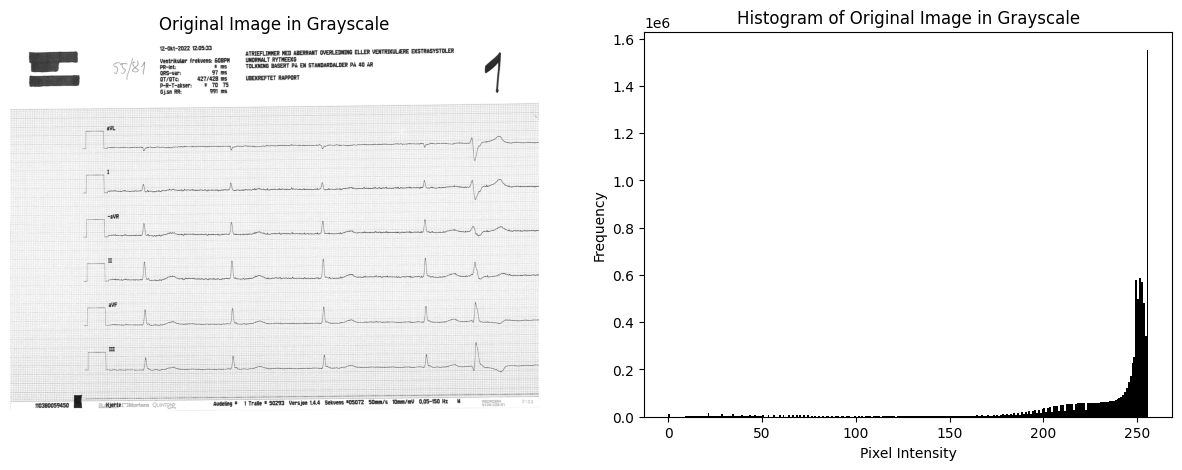

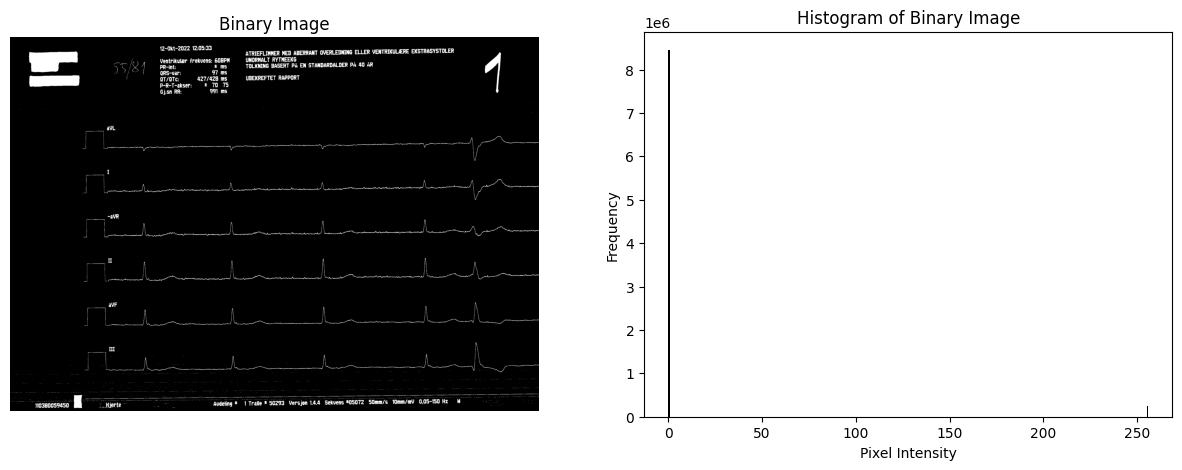

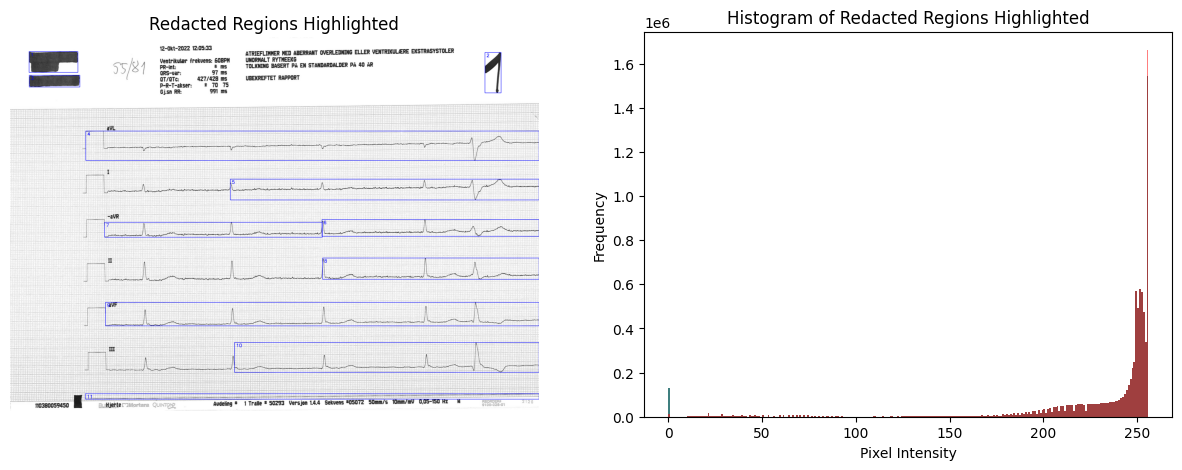

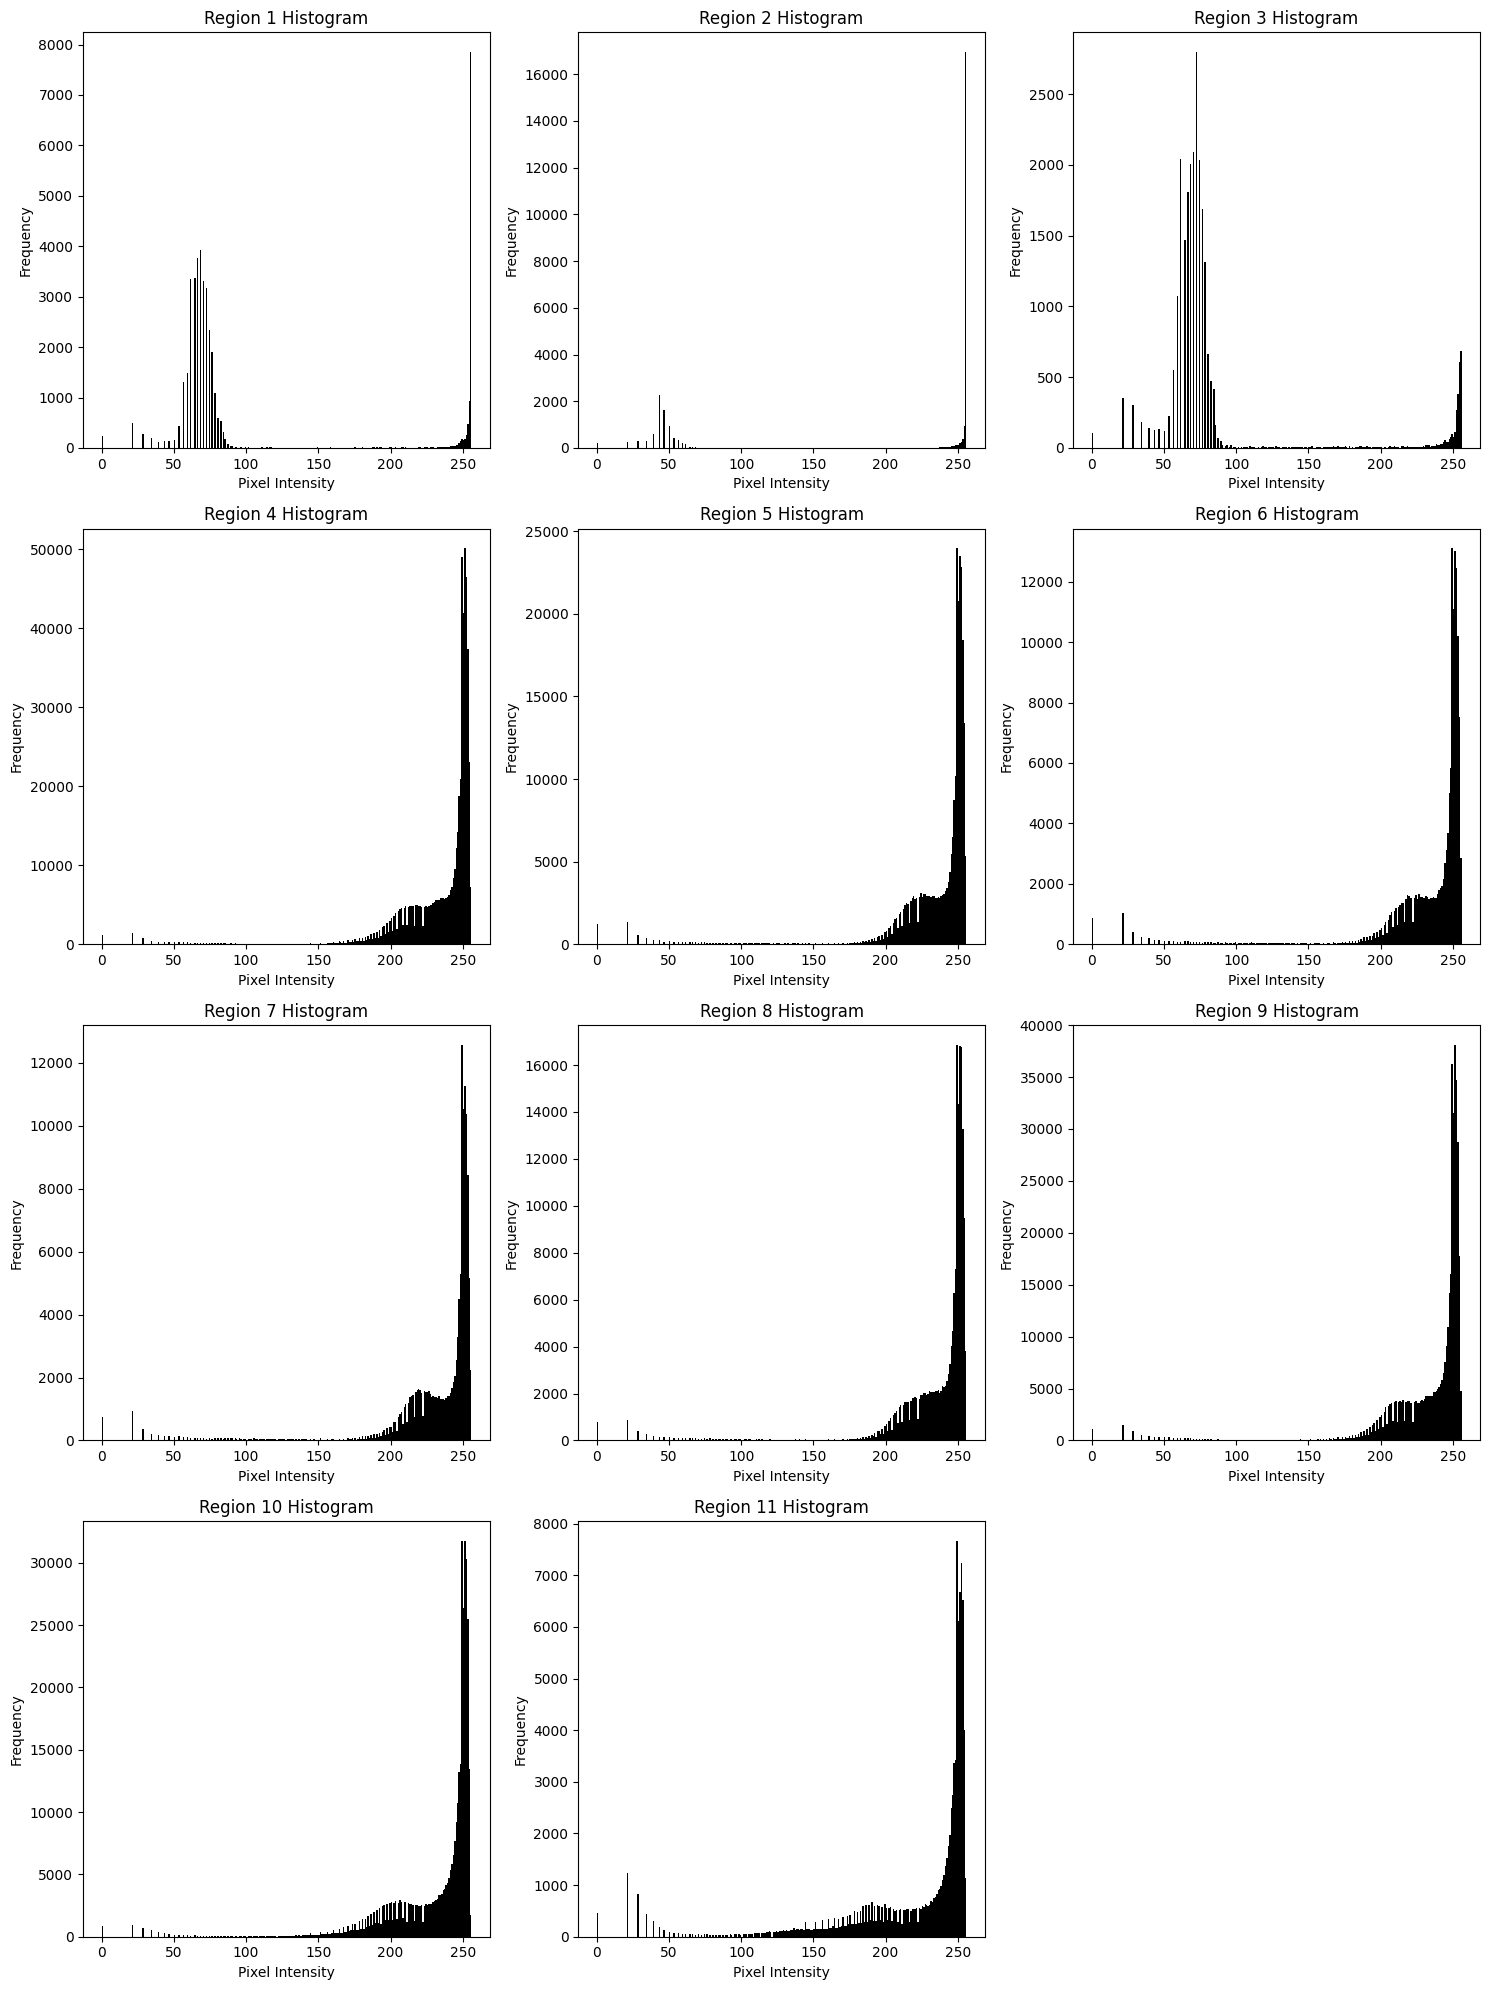

In [13]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from scipy.interpolate import interp1d
import csv
import sys

# Helper function to plot histograms for redacted regions
def plot_redacted_region_histograms(image, labels, stats, min_area=5000):
    num_labels = labels.max() + 1
    valid_regions = [(i, stats[i]) for i in range(1, num_labels) if stats[i, cv.CC_STAT_AREA] > min_area]

    num_regions = len(valid_regions)
    if num_regions == 0:
        print("No redacted regions found.")
        return

    # Determine grid size for subplots
    cols = 3  # Number of columns for subplots
    rows = ceil(num_regions / cols)  # Number of rows based on number of regions

    plt.figure(figsize=(15, 5 * rows))

    for idx, (i, stat) in enumerate(valid_regions):
        x = stat[cv.CC_STAT_LEFT]
        y = stat[cv.CC_STAT_TOP]
        w = stat[cv.CC_STAT_WIDTH]
        h = stat[cv.CC_STAT_HEIGHT]

        # Extract the region of interest
        redacted_region = image[y:y + h, x:x + w]

        # Plot the histogram for this redacted region
        plt.subplot(rows, cols, idx + 1)
        plt.hist(redacted_region.ravel(), bins=256, range=(0, 256), color='black')
        plt.title(f'Region {idx + 1} Histogram')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Apply binary thresholding to create a binary image
def create_binary_image(image, threshold=127):
    _, binary_image = cv.threshold(image, threshold, 255, cv.THRESH_BINARY_INV)
    return binary_image

def plot_redacted_regions(image, binary_image, min_area=5000):
    num_labels, labels, stats, _ = cv.connectedComponentsWithStats(binary_image, connectivity=8)

    # Create a color image for visualization
    color_image = cv.cvtColor(image, cv.COLOR_GRAY2BGR)

    # Initialize numbering
    region_number = 1

    for i in range(1, num_labels):  # Skip the background label 0
        area = stats[i, cv.CC_STAT_AREA]
        if area > min_area:
            # Extract bounding box coordinates (left, top, width, height)
            x = stats[i, cv.CC_STAT_LEFT]
            y = stats[i, cv.CC_STAT_TOP]
            w = stats[i, cv.CC_STAT_WIDTH]
            h = stats[i, cv.CC_STAT_HEIGHT]

            # Draw the bounding box in red
            cv.rectangle(color_image, (x, y), (x + w, y + h), (0, 0, 255), 2)

            # Put the number inside the redacted region
            label_position = (x + 10, y + 30)  # Adjust position as needed
            cv.putText(color_image, str(region_number), label_position, cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            
            # Increment the region number
            region_number += 1

    # Display the redacted regions with numbers
    plot_image_with_histogram(color_image, 'Redacted Regions Highlighted', cmap=None)

    # Plot histograms of redacted regions
    plot_redacted_region_histograms(image, labels, stats, min_area)

# Example function to plot an image and histogram (used previously)
def plot_image_with_histogram(image, title, cmap='gray'):
    plt.figure(figsize=(15, 5))

    # Plot image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')

    # Plot histogram
    plt.subplot(1, 2, 2)
    if len(image.shape) == 2:  # Grayscale image
        plt.hist(image.ravel(), bins=256, range=(0, 256), color='black')
    else:  # Color image
        for i, color in enumerate(['b', 'g', 'r']):
            plt.hist(image[:, :, i].ravel(), bins=256, range=(0, 256), color=color, alpha=0.5)
    plt.title(f'Histogram of {title}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    
    plt.show()

def main():
    image_name = 'input_png/1_F_page_1.png'

    # Step 1: Load and preprocess the image
    image = cv.imread(image_name, flags=cv.IMREAD_GRAYSCALE)
    if image is None:
        print('Cannot open image: ' + image_name)
        sys.exit(0)

    plot_image_with_histogram(image, 'Original Image in Grayscale')

    # Convert to binary image
    binary_image = create_binary_image(image, threshold=127)
    plot_image_with_histogram(binary_image, 'Binary Image')

    # Plot redacted regions and their histograms
    plot_redacted_regions(image, binary_image, min_area=5000)

if __name__ == '__main__':
    main()


The differentiation between redacted and non-redacted regions can be effectively achieved by analyzing pixel intensity distributions. 
Redacted regions seems to have a higher concentration of lower-intensity pixels, with frequencies typically exceeding 2,000 in the 0-100 intensity range. In contrast, non-redacted regions exhibit significantly lower frequencies in this range, making this histogram-based approach a reliable method for identifying redacted areas.

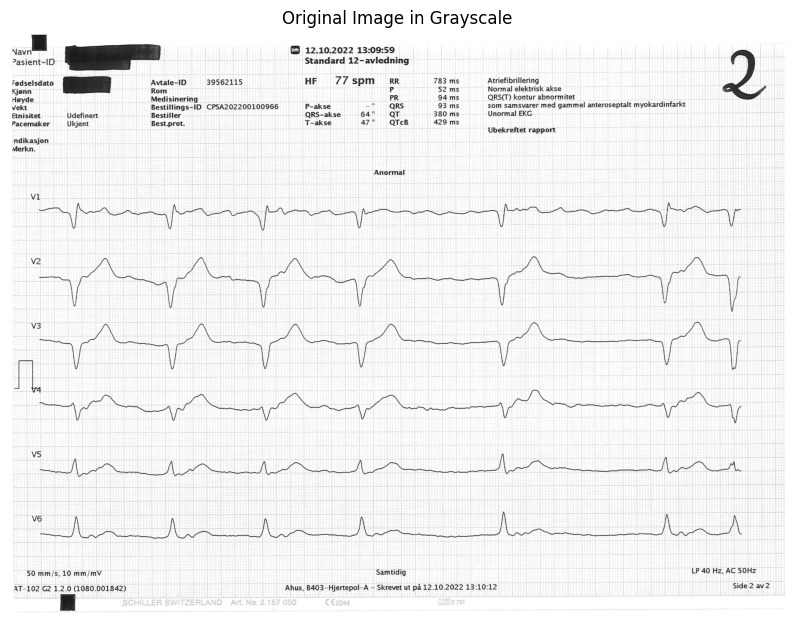

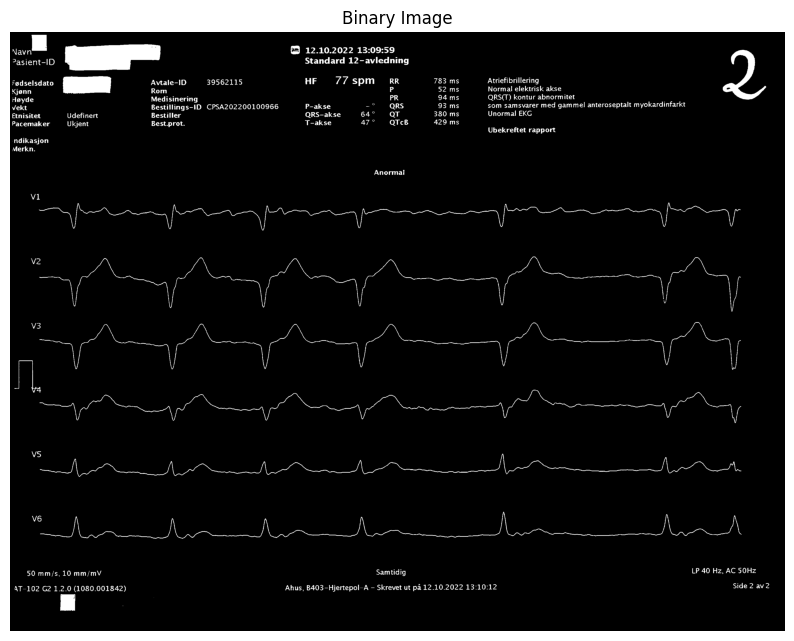

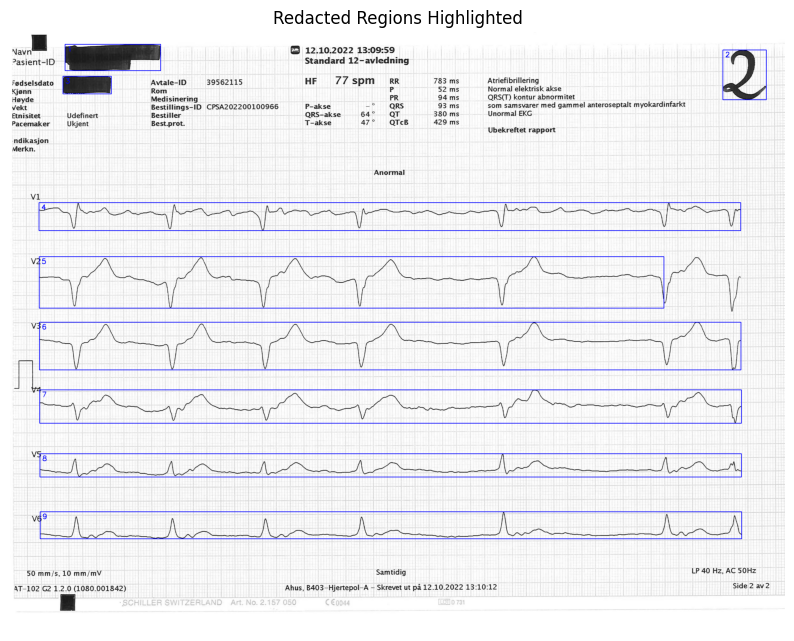

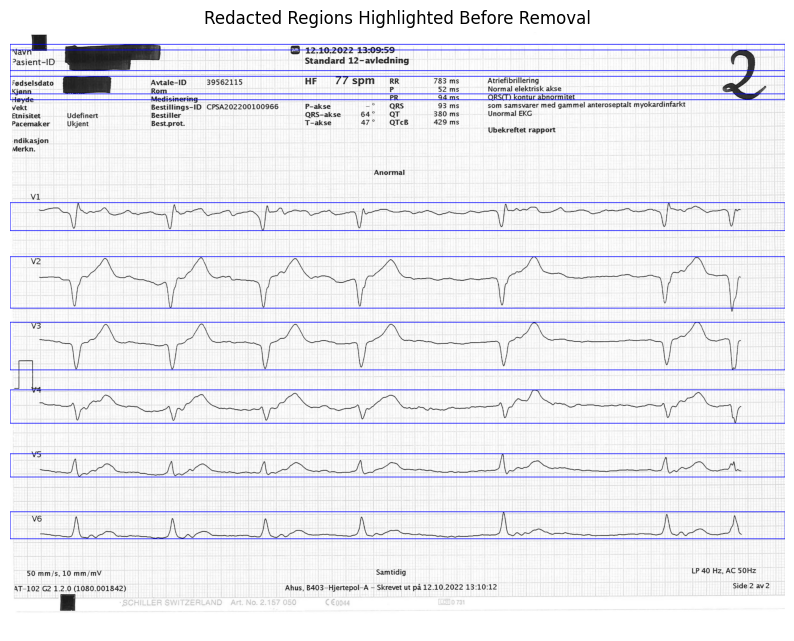

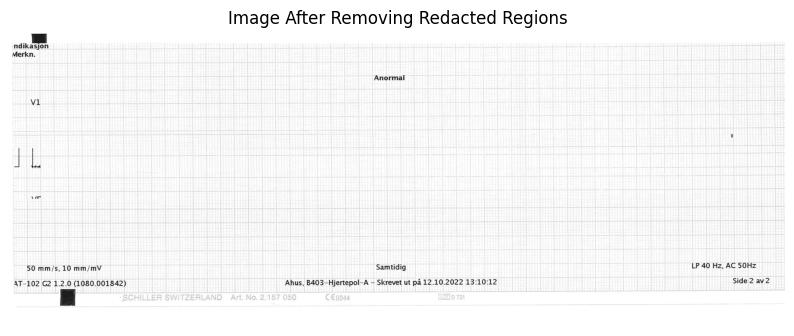

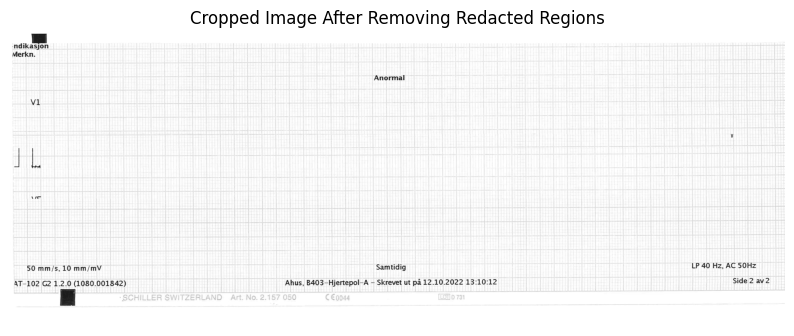

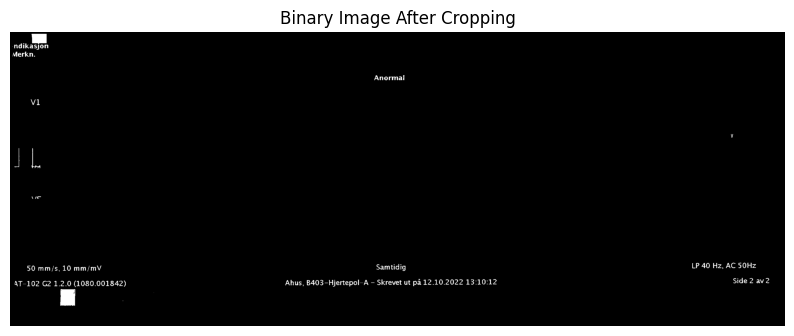

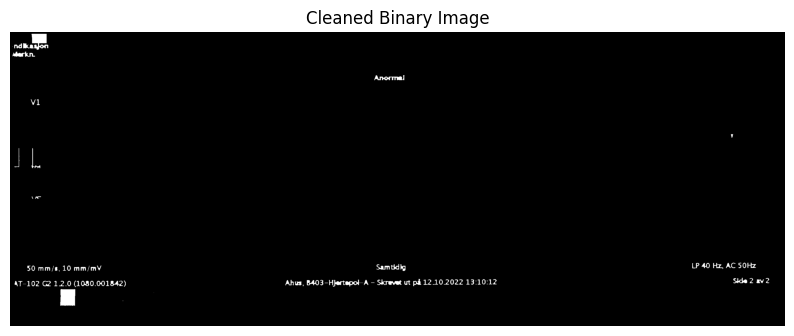

In [17]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import sys

# Helper function to plot images
def plot_image(image, title, cmap='gray'):
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Apply binary thresholding to create a binary image
def create_binary_image(image, threshold=127):
    _, binary_image = cv.threshold(image, threshold, 255, cv.THRESH_BINARY_INV)
    return binary_image

# Function to determine if a region is redacted based on histogram analysis
def is_redacted_region(region, intensity_threshold=100, frequency_threshold=2000):
    hist = cv.calcHist([region], [0], None, [256], [0, 256])
    if np.sum(hist[:intensity_threshold]) >= frequency_threshold:
        return True
    return False

# Function to crop out redacted regions based on histogram analysis
def crop_out_redacted_region(image, binary_image, min_area=5000):
    num_labels, labels, stats, _ = cv.connectedComponentsWithStats(binary_image, connectivity=8)

    redacted_regions = []

    for i in range(1, num_labels):  # Skip the background label 0
        area = stats[i, cv.CC_STAT_AREA]
        if area > min_area:
            # Extract bounding box coordinates (left, top, width, height)
            x = stats[i, cv.CC_STAT_LEFT]
            y = stats[i, cv.CC_STAT_TOP]
            w = stats[i, cv.CC_STAT_WIDTH]
            h = stats[i, cv.CC_STAT_HEIGHT]

            # Extract the region of interest
            region = image[y:y + h, x:x + w]

            # Determine if this region is redacted based on the histogram logic
            if is_redacted_region(region):
                redacted_regions.append((y, y + h))

    # Sort the regions from top to bottom
    redacted_regions.sort()

    cropped_image = image.copy()
    for top, bottom in redacted_regions[::-1]:  # Iterate from bottom to top to avoid index issues
        cropped_image = np.delete(cropped_image, np.s_[top:bottom], axis=0)

    # For debugging: visualize the removed regions on a color image
    color_image = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
    for top, bottom in redacted_regions:
        cv.rectangle(color_image, (0, top), (image.shape[1], bottom), (0, 0, 255), 2)
    plot_image(color_image, 'Redacted Regions Highlighted Before Removal', cmap=None)
    
    plot_image(cropped_image, 'Image After Removing Redacted Regions')

    return cropped_image

# Function to plot detected redacted regions
def plot_redacted_regions(image, binary_image, min_area=5000):
    num_labels, labels, stats, _ = cv.connectedComponentsWithStats(binary_image, connectivity=8)

    # Create a color image for visualization
    color_image = cv.cvtColor(image, cv.COLOR_GRAY2BGR)

    region_number = 1

    for i in range(1, num_labels):  # Skip the background label 0
        area = stats[i, cv.CC_STAT_AREA]
        if area > min_area:
            x = stats[i, cv.CC_STAT_LEFT]
            y = stats[i, cv.CC_STAT_TOP]
            w = stats[i, cv.CC_STAT_WIDTH]
            h = stats[i, cv.CC_STAT_HEIGHT]

            # Extract the region of interest
            region = image[y:y + h, x:x + w]

            if is_redacted_region(region):
                # Draw the bounding box in red
                cv.rectangle(color_image, (x, y), (x + w, y + h), (0, 0, 255), 2)

                # Put the number inside the redacted region
                label_position = (x + 10, y + 30)
                cv.putText(color_image, str(region_number), label_position, cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                
                region_number += 1

    plot_image(color_image, 'Redacted Regions Highlighted', cmap=None)

# Apply K-means clustering to segment the image
def apply_kmeans(image, n_clusters=2):
    Z = image.reshape((-1, 1))  # Flatten the image
    Z = np.float32(Z)

    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv.kmeans(Z, n_clusters, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

    segmented_image = labels.reshape((image.shape))

    return segmented_image, centers

# Apply morphological operations to clean the image
def clean_image(image):
    kernel = np.ones((5, 5), np.uint8)
    cleaned_image = cv.morphologyEx(image, cv.MORPH_CLOSE, kernel)
    return cleaned_image

# Main function
def main():
    image_name = 'input_png/2_F_page_2.png'

    image = cv.imread(image_name, flags=cv.IMREAD_GRAYSCALE)
    if image is None:
        print('Cannot open image: ' + image_name)
        sys.exit(0)

    plot_image(image, 'Original Image in Grayscale')

    binary_image = create_binary_image(image, threshold=127)
    plot_image(binary_image, 'Binary Image')

    plot_redacted_regions(image, binary_image, min_area=5000)

    cropped_image = crop_out_redacted_region(image, binary_image, min_area=5000)
    plot_image(cropped_image, 'Cropped Image After Removing Redacted Regions')

    binary_image2 = create_binary_image(cropped_image, threshold=127)
    plot_image(binary_image2, 'Binary Image After Cropping')

    cleaned_image = clean_image(binary_image2)
    plot_image(cleaned_image, 'Cleaned Binary Image')

    # Further processing steps can be added here as needed...

if __name__ == '__main__':
    main()
